In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import mapclassify
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import time
import random
import matplotlib.pyplot as plt
from shapely import wkt
import scipy 
from scipy import stats 
from libpysal.weights import Queen, KNN
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pygeoda
from esda.moran import Moran_BV
from tabulate import tabulate

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python

In [2]:
gdfjoined1 = gpd.read_file(r"/Users/yuhan/Desktop/paper——revision/export_results/df_localMoran_all2.shp")
gdfjoined2 = gpd.read_file(r"/Users/yuhan/Desktop/paper——revision/export_results/df_localMoran_declared2.shp")

usregions = gpd.read_file(r"/Users/yuhan/Downloads/cb_2018_us_region_500k/cb_2018_us_region_500k.shp")

gdfjoined3 = gpd.read_file(r"/Users/yuhan/Desktop/paper——revision/export_results/fema_projects_localMorans_all.shp")
gdfjoined4 = gpd.read_file(r"/Users/yuhan/Desktop/paper——revision/export_results/fema_projects_localMorans_declared.shp")


In [3]:
print( gdfjoined1.columns)
print( "us region crs", usregions.crs )
usregions = usregions.to_crs({'init':'epsg:2163'})
print( "changed us region crs", usregions.crs )
print( gdfjoined1.crs )
usregions = usregions[ ["REGIONCE", "NAME", "AWATER", "geometry"] ]


Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'AdminCostA', 'NumfinalPr', 'CropDmg',
       'CropDmg(AD', 'CropDmgPer', 'PropertyDm', 'Property_1', 'Property_2',
       'Injuries', 'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D',
       'PAprojectA', 'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount',
       'HAtotal', 'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'cbsa', 'totalAssis', 'totalAss_1',
       'totalDamag', 'DamageSOVI', 'totalDam_1', 'totalAss_2', 'DamageSO_1',
       'label1', 'x1', 'p_sim1', 'MoranI1', 'color1', 'label2', 'x2', 'p_sim2',
       'MoranI2', 'color2', 'REGIONCE', 'NAME_2', 'AWATER', 'geometry'],
      dtype='object')
us region crs EPSG:4269
changed us region crs +init=epsg:2163 +type=crs
None


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [173]:

usregions.to_file(r"/Users/yuhan/Desktop/paper——revision/export_results/usregions.shp")

In [136]:
from functools import reduce
df_total_lisa = pd.merge(gdfjoined1[ ['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 
                                      'POPULATION', 'SOVI_SCORE', 'cbsa', 'totalAssis', 'totalDamag', 
                                      'label1', 'p_sim1', 'MoranI1',  
                                      'label2', 'p_sim2', 'MoranI2' ] ], 
        gdfjoined2[ ['STCOFIPS', 'totalDamag', 
                     'label1', 'p_sim1', 'MoranI1', 
                     'label2', 'p_sim2', 'MoranI2'] ],on= ['STCOFIPS'])

df_total_lisa.columns = ['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 
                         'POPULATION', 'SOVI_SCORE', 'cbsa', 'atotalAssis', 'atotalDamag', 
                         'alabel1', 'ap_sim1', 'aMoranI1', 'alabel2', 'ap_sim2', 'aMoranI2',
                         'dtotalDamag', 'dlabel1', 'dp_sim1', 'dMoranI1', 'dlabel2', 'dp_sim2', 
                         'dMoranI2' ]

df_total_lisa.head()


,STATE,STATEABBRV,COUNTY,COUNTYFIPS,STCOFIPS,POPULATION,SOVI_SCORE,cbsa,atotalAssis,atotalDamag,...,alabel2,ap_sim2,aMoranI2,dtotalDamag,dlabel1,dp_sim1,dMoranI1,dlabel2,dp_sim2,dMoranI2
0,Alabama,AL,Autauga,001,01001,58764,51.299999,Montgomery,1.005660e+07,3.366930e+07,...,0,0.172,0.021272,1.652280e+07,0,0.093,0.398505,0,0.093,0.028855
1,Alabama,AL,Baldwin,003,01003,231365,31.030001,Daphne-Fairhope-Foley,2.668501e+09,3.033512e+09,...,2,0.009,-0.531368,2.975938e+09,1,0.001,1.248618,2,0.004,-0.591564
2,Alabama,AL,Barbour,005,01005,25160,99.269997,Eufaula,3.436997e+05,1.764000e+06,...,0,0.310,0.328383,5.875000e+05,0,0.162,0.071650,0,0.162,0.591328
3,Alabama,AL,Bibb,007,01007,22239,80.779999,Birmingham-Hoover,3.176140e+07,8.862450e+07,...,1,0.024,0.755644,8.773650e+07,1,0.009,0.708979,1,0.013,0.846542
4,Alabama,AL,Blount,009,01009,58992,51.369999,Birmingham-Hoover,6.849714e+07,2.016785e+08,...,1,0.022,0.036947,1.972540e+08,1,0.007,0.824279,1,0.009,0.041459


In [141]:
df_total_lisa["city"] = df_total_lisa.cbsa.str.split("-", expand=True)[0] + "," + df_total_lisa.STATEABBRV
df_total_lisa["county"] =  df_total_lisa["COUNTY"] + "," + df_total_lisa.STATEABBRV
print( df_total_lisa["county"].head() )
print( df_total_lisa["city"].head() )


0    Autauga,AL
1    Baldwin,AL
2    Barbour,AL
3       Bibb,AL
4     Blount,AL
Name: county, dtype: object
0    Montgomery,AL
1        Daphne,AL
2       Eufaula,AL
3    Birmingham,AL
4    Birmingham,AL
Name: city, dtype: object


In [142]:
df_total_lisa.to_csv(r"/Users/yuhan/Desktop/paper——revision/export_results/df_total_lisa.csv", index=False)


In [145]:
df_total_lisa['city'] = df_total_lisa['city'].fillna( df_total_lisa['county']).head()
print( df_total_lisa.columns )
print( df_total_lisa.head() )


Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'SOVI_SCORE', 'cbsa', 'atotalAssis', 'atotalDamag', 'alabel1',
       'ap_sim1', 'aMoranI1', 'alabel2', 'ap_sim2', 'aMoranI2', 'dtotalDamag',
       'dlabel1', 'dp_sim1', 'dMoranI1', 'dlabel2', 'dp_sim2', 'dMoranI2',
       'city', 'county'],
      dtype='object')
     STATE STATEABBRV   COUNTY COUNTYFIPS STCOFIPS  POPULATION  SOVI_SCORE  \
0  Alabama         AL  Autauga        001    01001       58764   51.299999   
1  Alabama         AL  Baldwin        003    01003      231365   31.030001   
2  Alabama         AL  Barbour        005    01005       25160   99.269997   
3  Alabama         AL     Bibb        007    01007       22239   80.779999   
4  Alabama         AL   Blount        009    01009       58992   51.369999   

                    cbsa   atotalAssis   atotalDamag  ...  aMoranI2  \
0             Montgomery  1.005660e+07  3.366930e+07  ...  0.021272   
1  Daphne-Fairhope-Foley  2.668501e+0

In [155]:
df_total_lisa2 = df_total_lisa.groupby([ 'city'], as_index=False).agg({  
    "POPULATION" : ['sum'], "atotalDamag": ['sum'],
    "atotalAssis": ['sum'], "SOVI_SCORE" : ['mean'], 
    "aMoranI1": ['mean'] , "aMoranI2": ['mean'], 
    "alabel1": pd.Series.mode, "alabel2": pd.Series.mode   })
df_total_lisa2.columns = df_total_lisa2.columns.droplevel(1)
df_total_lisa2.columns = [ 'city', 'POPULATION', "atotalDamag" ,
                       'atotalAssis', 'SOVI_SCORE', 'aMoranI1' , 'aMoranI2' , "alabel1", "alabel2"]

df_total_lisa2.to_csv(r"/Users/yuhan/Desktop/paper——revision/export_results/df_citymean_lisa.csv", index=False)


In [160]:
usregions.head()

,REGIONCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,1,0200000US1,1,Northeast,68,419357835545,50259300137,"MULTIPOLYGON (((2446153.061 407460.300, 244636..."
1,2,0200000US2,2,Midwest,68,1943997274253,184273267512,"MULTIPOLYGON (((1422979.278 -227154.171, 14231..."
2,4,0200000US4,4,West,68,4536201747682,316587292459,"MULTIPOLYGON (((-4288629.978 3426273.416, -428..."
3,3,0200000US3,3,South,68,2249871668369,134084610547,"MULTIPOLYGON (((2060803.219 -301773.581, 20609..."


In [175]:
gdfjoined1.columns


Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'AdminCostA', 'NumfinalPr', 'CropDmg',
       'CropDmg(AD', 'CropDmgPer', 'PropertyDm', 'Property_1', 'Property_2',
       'Injuries', 'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D',
       'PAprojectA', 'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount',
       'HAtotal', 'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'cbsa', 'totalAssis', 'totalAss_1',
       'totalDamag', 'DamageSOVI', 'totalDam_1', 'totalAss_2', 'DamageSO_1',
       'label1', 'x1', 'p_sim1', 'MoranI1', 'color1', 'label2', 'x2', 'p_sim2',
       'MoranI2', 'color2', 'REGIONCE', 'NAME_2', 'AWATER', 'geometry'],
      dtype='object')

In [ ]:

def percentile_rank(column):
   return column.rank(pct = True)

gdfjoinedx1 = gdfjoined1.groupby([ 'NAME_2'], as_index=False).agg({  
    "POPULATION" : ['sum'], "totalDamag": ['sum'],
    "totalAssis": ['sum'], "SOVI_SCORE" : ['mean'], 
    "MoranI1": ['mean'] , "MoranI2": ['mean'] ,
    "alabel1": ['mode'], "alabel2": ['mode']  })
gdfjoinedx1.columns = gdfjoinedx1.columns.droplevel(1)
gdfjoinedx1.columns = [ 'NAME', 'cbsa', 'POPULATION', 'totalDamag', 
                       'totalAssis', 'SOVI_SCORE', 'aMoranI1' , 'aMoranI2', 'acount' ]

gdfjoinedx1.head()
print( gdfjoined1.MoranI1.mean(), gdfjoined1.MoranI1.std() )
print( gdfjoined1.MoranI2.mean(), gdfjoined1.MoranI2.std() )


In [181]:
gdfjoined1.NAME_2.unique()

array(['Northeast', 'Midwest', 'West', 'South'], dtype=object)

In [185]:
print( gdfjoined2.loc[ gdfjoined2['NAME_2'] == 'Northeast' ].label1.value_counts() )
print( gdfjoined2.loc[ gdfjoined2['NAME_2'] == 'Midwest' ].label1.value_counts() )
print( gdfjoined2.loc[ gdfjoined2['NAME_2'] == 'West' ].label1.value_counts() )
print( gdfjoined2.loc[ gdfjoined2['NAME_2'] == 'South' ].label1.value_counts() )


label1
0    124
1     89
3      8
4      5
2      2
Name: count, dtype: int64
label1
0    810
3    158
1    119
4     51
2      4
Name: count, dtype: int64
label1
3    294
0    120
4     21
1      9
2      2
Name: count, dtype: int64
label1
0    999
1    320
3     90
4     35
2     26
Name: count, dtype: int64


In [184]:
print( gdfjoined1.loc[ gdfjoined1['NAME_2'] == 'Northeast' ].label2.value_counts() )
print( gdfjoined1.loc[ gdfjoined1['NAME_2'] == 'Midwest' ].label2.value_counts() )
print( gdfjoined1.loc[ gdfjoined1['NAME_2'] == 'West' ].label2.value_counts() )
print( gdfjoined1.loc[ gdfjoined1['NAME_2'] == 'South' ].label2.value_counts() )


label2
0    122
2     61
1     35
3      6
4      4
Name: count, dtype: int64
label2
0    869
3    136
2     59
4     41
1     37
Name: count, dtype: int64
label2
0    229
3    115
4     89
1      8
2      5
Name: count, dtype: int64
label2
0    1009
1     250
4      97
2      64
3      50
Name: count, dtype: int64


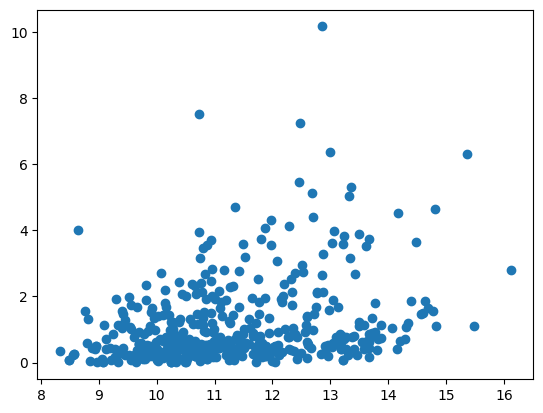

In [6]:
plt.scatter( np.log(gdfjoined1.loc[ gdfjoined1['label1'] == 1 ].POPULATION+1), gdfjoined1.loc[ gdfjoined1['label1'] == 1 ].MoranI1)

In [93]:
gdfjoinedx3 = gdfjoined3.loc[ 
   gdfjoined3['cbsa'] != '0' ].groupby([ 'NAME', 'cbsa'], as_index=False).agg({  
    "POPULATION" : ['sum'], "totalDamag": ['sum'],
    "totalAssis": ['sum'], "SOVI_SCORE" : ['mean'], 
    "Moran1": ['mean'] , "Moran2": ['mean'] , "Moran3": ['mean'] , "Moran4": ['mean'] ,
    "Moran5": ['mean'] , "Moran6": ['mean'] , "Moran7": ['mean'] , "Moran8": ['mean'] ,
    "Moran9": ['mean'] , "Moran10": ['mean'] , "label1": ['count']  })
gdfjoinedx3.columns = gdfjoinedx3.columns.droplevel(1)
gdfjoinedx3.head()

datax3 = tabulate([[gdfjoined3.Moran1.mean(), gdfjoined3.Moran1.std()], 
                [gdfjoined3.Moran2.mean(), gdfjoined3.Moran2.std()],
                [gdfjoined3.Moran3.mean(), gdfjoined3.Moran3.std()],
                [gdfjoined3.Moran4.mean(), gdfjoined3.Moran4.std() ],
                [gdfjoined3.Moran5.mean(), gdfjoined3.Moran5.std()],
                [gdfjoined3.Moran6.mean(), gdfjoined3.Moran6.std()],
                [gdfjoined3.Moran7.mean(), gdfjoined3.Moran7.std()],
                [ gdfjoined3.Moran9.mean(), gdfjoined3.Moran8.std()],
                [gdfjoined3.Moran9.mean(), gdfjoined3.Moran9.std()],
                [ gdfjoined3.Moran10.mean(), gdfjoined3.Moran10.std()]
                ], headers=['mean', 'std'], tablefmt='orgtbl')

#text_file=open("/Users/yuhan/Desktop/paper——revision/Writings/datax_all_cate_lisa.csv","w")
#text_file.write( datax3 )
#text_file.close()

In [86]:
gdfjoinedx4 = gdfjoined4.loc[ 
   gdfjoined4['cbsa'] != '0' ].groupby([ 'NAME', 'cbsa'], as_index=False).agg({  
    "POPULATION" : ['sum'], "totalDamag": ['sum'],
    "totalAssis": ['sum'], "SOVI_SCORE" : ['mean'], 
    "Moran1": ['mean'] , "Moran2": ['mean'] , "Moran3": ['mean'] , "Moran4": ['mean'] ,
    "Moran5": ['mean'] , "Moran6": ['mean'] , "Moran7": ['mean'] , "Moran8": ['mean'] ,
    "Moran9": ['mean'] , "Moran10": ['mean'] , "label1": ['count']  })
gdfjoinedx4.columns = gdfjoinedx4.columns.droplevel(1)
gdfjoinedx4.columns = gdfjoinedx4.columns

datax4 = tabulate([[gdfjoined4.Moran1.mean(), gdfjoined4.Moran1.std()], 
                [gdfjoined4.Moran2.mean(), gdfjoined4.Moran2.std()],
                [gdfjoined4.Moran3.mean(), gdfjoined4.Moran3.std()],
                [gdfjoined4.Moran4.mean(), gdfjoined4.Moran4.std() ],
                [gdfjoined4.Moran5.mean(), gdfjoined4.Moran5.std()],
                [gdfjoined4.Moran6.mean(), gdfjoined4.Moran6.std()],
                [gdfjoined4.Moran7.mean(), gdfjoined4.Moran7.std()],
                [ gdfjoined4.Moran9.mean(), gdfjoined4.Moran8.std()],
                [gdfjoined4.Moran9.mean(), gdfjoined4.Moran9.std()],
                [ gdfjoined4.Moran10.mean(), gdfjoined4.Moran10.std()]  ], headers=['mean', 'std'], tablefmt='orgtbl')

#text_file=open("/Users/yuhan/Desktop/paper——revision/Writings/datax_declared_cate_lisa.csv","w")
#text_file.write( datax4 )
#text_file.close()


In [87]:
dfList = [ gdfjoinedx1, gdfjoinedx2, gdfjoinedx3, gdfjoinedx4 ]
from functools import reduce
df_total_lisa = reduce(lambda df1,df2: pd.merge(df1,df2,on='cbsa'), dfList)

MergeError: Passing 'suffixes' which cause duplicate columns {'totalDamag_x', 'POPULATION_x', 'label1_x', 'totalAssis_x', 'SOVI_SCORE_x', 'NAME_x'} is not allowed.

In [68]:
#gdfjoined4 = gdfjoined4

print( gdfjoined4.loc[ gdfjoined4["label1"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label1"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label1"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label1"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label1"] == 4 ].shape[0] )


2183
491
37
176
221


In [69]:

print( gdfjoined4.loc[ gdfjoined4["label2"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label2"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label2"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label2"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label2"] == 4 ].shape[0] )


2022
493
47
356
190


In [70]:

print( gdfjoined4.loc[ gdfjoined4["label3"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label3"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label3"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label3"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label3"] == 4 ].shape[0] )


1796
566
53
481
212


In [71]:

print( gdfjoined4.loc[ gdfjoined4["label4"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label4"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label4"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label4"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label4"] == 4 ].shape[0] )


2355
312
59
70
312


In [72]:

print( gdfjoined4.loc[ gdfjoined4["label5"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label5"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label5"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label5"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label5"] == 4 ].shape[0] )


1974
203
15
67
849


In [73]:

print( gdfjoined4.loc[ gdfjoined4["label6"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label6"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label6"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label6"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label6"] == 4 ].shape[0] )


2145
350
189
158
266


In [74]:

print( gdfjoined4.loc[ gdfjoined4["label7"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label7"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label7"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label7"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label7"] == 4 ].shape[0] )


1945
294
224
337
308


In [75]:

print( gdfjoined4.loc[ gdfjoined4["label8"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label8"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label8"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label8"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label8"] == 4 ].shape[0] )


1839
352
245
383
289


In [76]:

print( gdfjoined4.loc[ gdfjoined4["label9"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label9"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label9"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label9"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label9"] == 4 ].shape[0] )


2329
235
130
130
284


In [77]:

print( gdfjoined4.loc[ gdfjoined4["label10"] == 0 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label10"] == 1 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label10"] == 2 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label10"] == 3 ].shape[0] )
print( gdfjoined4.loc[ gdfjoined4["label10"] == 4 ].shape[0] )


2252
106
103
104
543
